In [1]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Setup and Data Preparation

In [2]:

# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import os
import seaborn as sns

os.getcwd()

'/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook'

### DATA PREPARATION

In [40]:
df = pd.read_csv("../data/final_dataset.csv")

# Create categorical cheating behavior variable
def cheating_behavior(cheating_rate):
    return 0 if cheating_rate == 0 else (2 if cheating_rate == 1 else 1)  # Non-cheater=0, Full cheater=2, Partial cheater=1

df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)  # algorithm is in {game-behavior-analytics/cheating_analysis/cheating_analyzer.py}
df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2  # average of task satisfaction and task engagement
df["performance"] = df["performance_score_including_cheated_words"]  # performance includes legitimate + cheated words

# Drop rows with missing key outcome or predictor variables
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])


# Prepare data splits
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

# We use this naming convention:
# Intervention (1=concept-based message shown; 0=control) → Concept (15 concepts from 4 theories) → Motivational Message (3 variations per concept)

concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

# Extract outcome and predictor arrays
y_cheating_behavior = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values
is_partialCheater, is_fullCheater = (y_cheating_behavior == 1).astype(int), (y_cheating_behavior == 2).astype(int)

# Standard deviations
perf_std, exp_std = np.std(y_performance), np.std(y_experience)

# Control group baselines
control_data = df[df['concept'] == 'control']
control_cheating_dist = control_data['cheating_behavior'].value_counts(normalize=True).sort_index()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()




### Explorative Analysis: through Visualization of potential source of cheaters in intervention groups from control's performance distribution

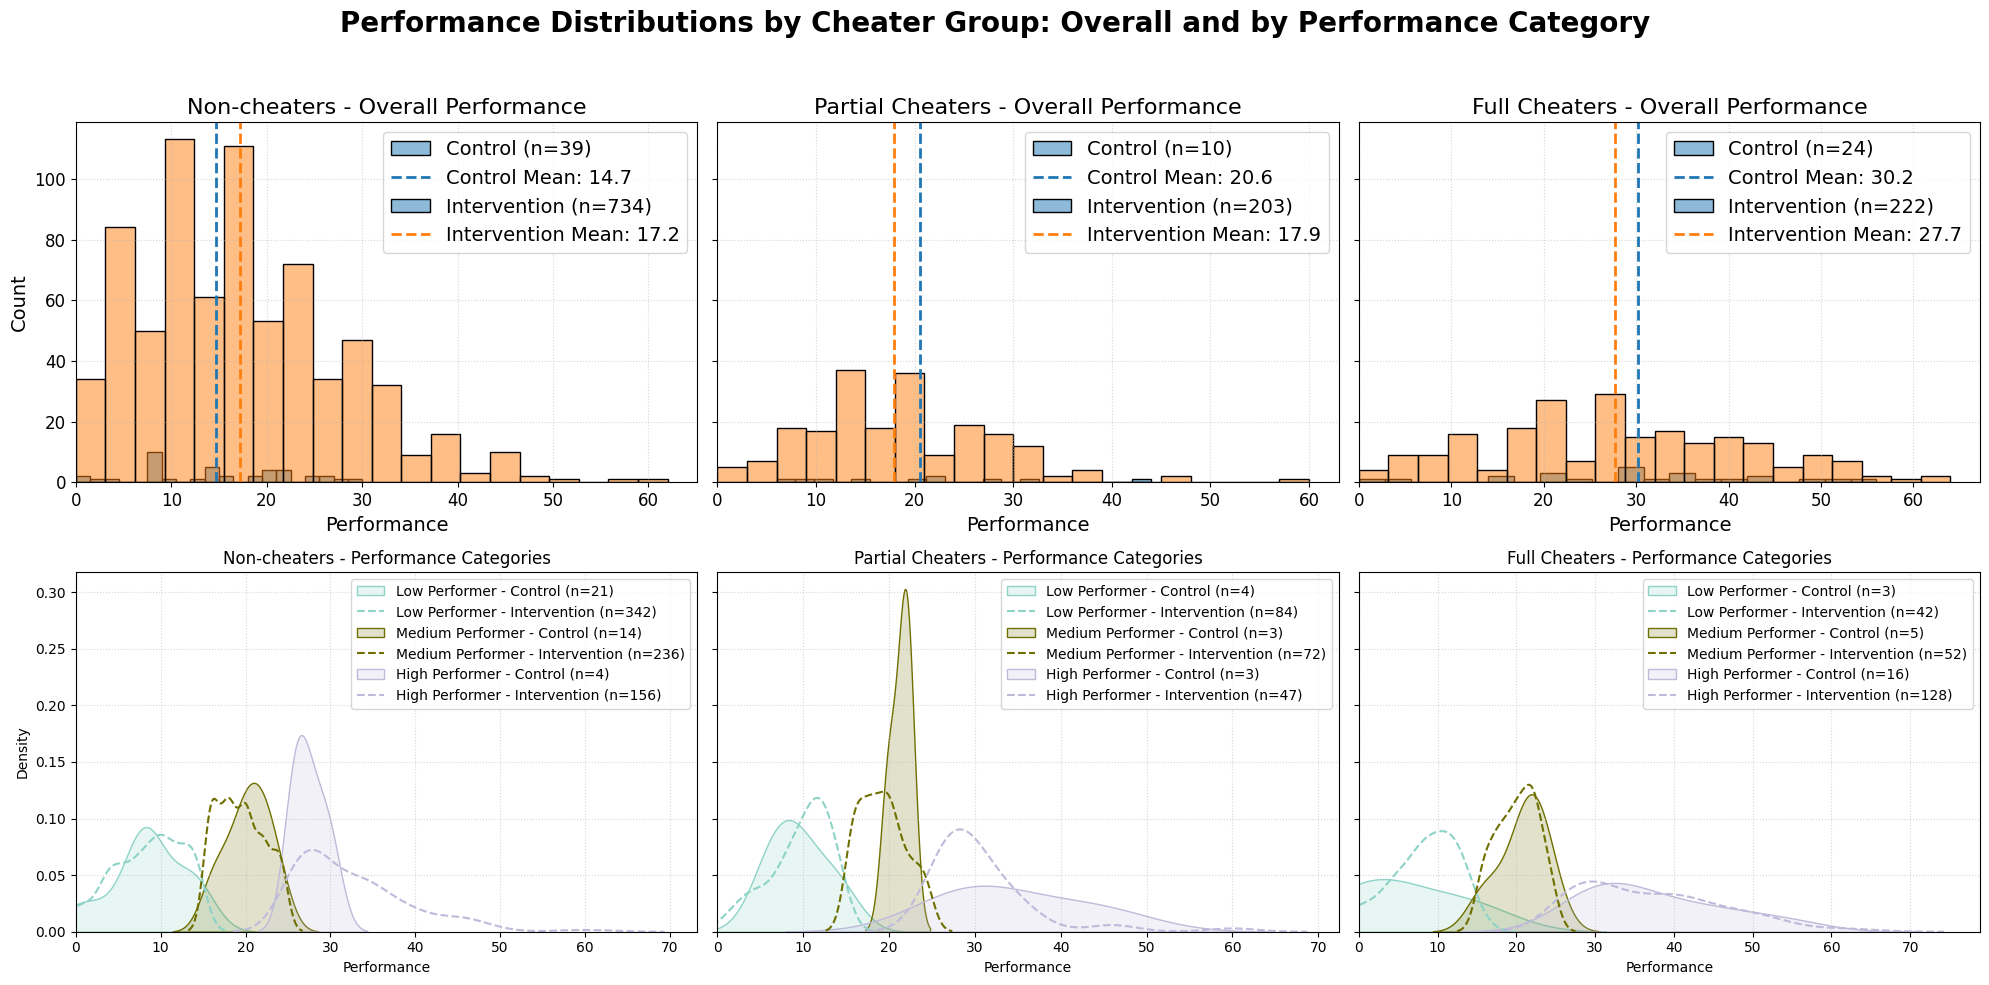

In [ ]:
# =======================================================================================
# PERFORMANCE DISTRIBUTIONS FOR CONTROL vs INTERVENTION GROUPS
# =======================================================================================

# Define labels and colors
cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Full Cheaters'}
colors = ['#2E8B57', '#FF8C00', '#DC143C']
cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Full Cheaters'}
category_colors = {'Low Performer': '#8dd3c7', 'Medium Performer': "#6f6f00", 'High Performer': '#bebada'}
control_color = '#1f77b4'
intervention_color = '#ff7f0e'

# Function to plot overall performance for a cheater group
def plot_cheater_group(ax, control_df, intervention_df, cheat_cat):
    label = cheating_labels[cheat_cat]
    
    control_subset = control_df[control_df['cheating_behavior'] == cheat_cat]['performance'].dropna()
    control_subset = control_subset[control_subset >= 0]
    
    intervention_subset = intervention_df[intervention_df['cheating_behavior'] == cheat_cat]['performance'].dropna()
    intervention_subset = intervention_subset[intervention_subset >= 0]
    
    handles = []
    labels = []
    
    # Plot histogram for control
    if len(control_subset) >= 3:
        hist = sns.histplot(control_subset, ax=ax, bins=20, color=control_color, alpha=0.5, 
                            edgecolor='black')
        mean_val = control_subset.mean()
        mean_line = ax.axvline(mean_val, color=control_color, linestyle='--', linewidth=2)
        
        handles.extend([hist.patches[0], mean_line])
        labels.extend([f"Control (n={len(control_subset)})", f"Control Mean: {mean_val:.1f}"])
    
    # Plot histogram for intervention
    if len(intervention_subset) >= 3:
        hist = sns.histplot(intervention_subset, ax=ax, bins=20, color=intervention_color, alpha=0.5, 
                            edgecolor='black')
        mean_val = intervention_subset.mean()
        mean_line = ax.axvline(mean_val, color=intervention_color, linestyle='--', linewidth=2)
        
        handles.extend([hist.patches[0], mean_line])
        labels.extend([f"Intervention (n={len(intervention_subset)})", f"Intervention Mean: {mean_val:.1f}"])
    
    ax.set_title(f"{label} - Overall Performance", fontsize=16)
    ax.set_xlabel("Performance", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(left=0)
    ax.legend(handles=handles, labels=labels, fontsize=14)
    ax.grid(True, linestyle=':', alpha=0.5)


# Function to plot performance by performance category within a cheater group
def plot_cheater_group_by_perf_cat(ax, control_df, intervention_df, cheat_cat):
    label = cheating_labels[cheat_cat]
    
    for category in ['Low Performer', 'Medium Performer', 'High Performer']:
        # Control subset
        c_subset = control_df[
            (control_df['cheating_behavior'] == cheat_cat) &
            (control_df['performance_category'] == category)
        ]['performance'].dropna()
        c_subset = c_subset[c_subset >= 0]
        
        # Intervention subset
        i_subset = intervention_df[
            (intervention_df['cheating_behavior'] == cheat_cat) &
            (intervention_df['performance_category'] == category)
        ]['performance'].dropna()
        i_subset = i_subset[i_subset >= 0]
        
        # Plot if sufficient data
        if len(c_subset) >= 3:
            sns.kdeplot(c_subset, ax=ax, fill=True, alpha=0.2, color=category_colors[category],
                        label=f"{category} - Control (n={len(c_subset)})")
        
        if len(i_subset) >= 3:
            sns.kdeplot(i_subset, ax=ax, fill=False, linestyle='--', color=category_colors[category],
                        label=f"{category} - Intervention (n={len(i_subset)})")
    
    ax.set_title(f"{label} - Performance Categories")
    ax.set_xlabel("Performance")
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# =======================================================================================
# PLOTTING 2x3 GRID: top row = overall; bottom row = performance categories
# =======================================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey='row')
fig.suptitle("Performance Distributions by Cheater Group: Overall and by Performance Category", fontsize=20, fontweight='bold')

for i, cheat_cat in enumerate([0,1,2]):
    # Top row
    plot_cheater_group(axes[0,i], control_data, intervention_data, cheat_cat)
    
    # Bottom row
    plot_cheater_group_by_perf_cat(axes[1,i], control_data, intervention_data, cheat_cat)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Skipped cell
<!-- #### Interpretation of the results above:

1. High performers can have **biggest impacts by interventions**
    - In the control, ~70% of high performers were full cheaters. Under intervention, this dropped dramatically to ~40% (↓30%).
    - The non-cheater proportion among high performers nearly tripled (~18% → ~47%). That ~30% could have moved from full cheaters to non-cheaters.
    - Interpretation: 
        - The interventions substantially could reduce cheating among high performers. It suggests that high performers might have the skills to achieve high scores without cheating but chose to cheat in control.
        - Under interventions (e.g. motivational messaging), they may choose honesty over maximizing scores without sacrificing experience (ΔExperience ≈ 0).

2. Medium performers can show **smaller cheating reductions**, but can show interesting patterns:
    - Full cheaters among medium performers reduced slightly (~23% → ~15%), a -8% change.
    - Partial cheaters increased (~14% → 20%, +6%).
    - Interpretation: 
        - Some full cheaters may have downgraded to partial cheating, and a small portion could become fully honest (non-cheaters ↑~2%).
        - Experience ratings for full cheaters in this group increased by +0.55, suggesting that interventions might have been helping them to be better engaged and satisfied.

3. Low performers were already **mostly honest**
    - Both in control and intervention, ~75% were non-cheaters. Very little change in cheating behavior:
        - Full cheaters reduced by only ~2%.
        - Partial cheaters increased by ~4% (from non-cheaters or full cheaters).
    - Experience: Low performer partial cheaters experienced a 1-point drop in experience under intervention.
        - This might imply: Messaging or intervention-induced guilt or inadequacy feelings among low performers who still cheated partially.


#### Key Takeaways:
##### Our interventions may not make weaker players cheat more if they are already mostly honest. The most notable effect we could see among high performers, where cheating can drastically be reduced under interventions without harming their experience. This suggests that behavioral interventions can transform those with the greatest capacity to cheat without diminishing their task engagement or satisfaction. -->

### Model 1: Cheating Behavior (Multinomial Logistic)

#### What this model does:
- Predicts probability of being non-cheater (reference), partial cheater, or full cheater
- Compares control group vs individual concepts using multinomial logistic regression

#### What we are looking for:
- Do interventions reduce cheating compared to control?
- Which concepts are most effective at reducing different types of cheating?
- Separate effects for partial vs full cheating behavior

#### Key Findings:
- **Partial cheating reduction**: 46% odds reduction [-69%, -29%], P(reduction)=1.000
- **Full cheating reduction**: 39% odds reduction [-59%, -24%], P(reduction)=1.000  
- **Most effective concepts**: Cognitive Inconsistency, Reference Group Identification, Verbal Persuasion
- **Effect measurement**: Log odds converted to percentage odds reductions



MODEL 1: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)
Fitting multinomial cheating behavior model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partialcheaters_intercept, beta_fullcheaters_intercept, concept_effects_partialcheaters, concept_effects_fullcheaters, message_effects_partialcheaters, message_effects_fullcheaters]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 22 seconds.
Sampling: [cheating_obs]


Output()

Model fitted successfully!
Performing posterior predictive checks...


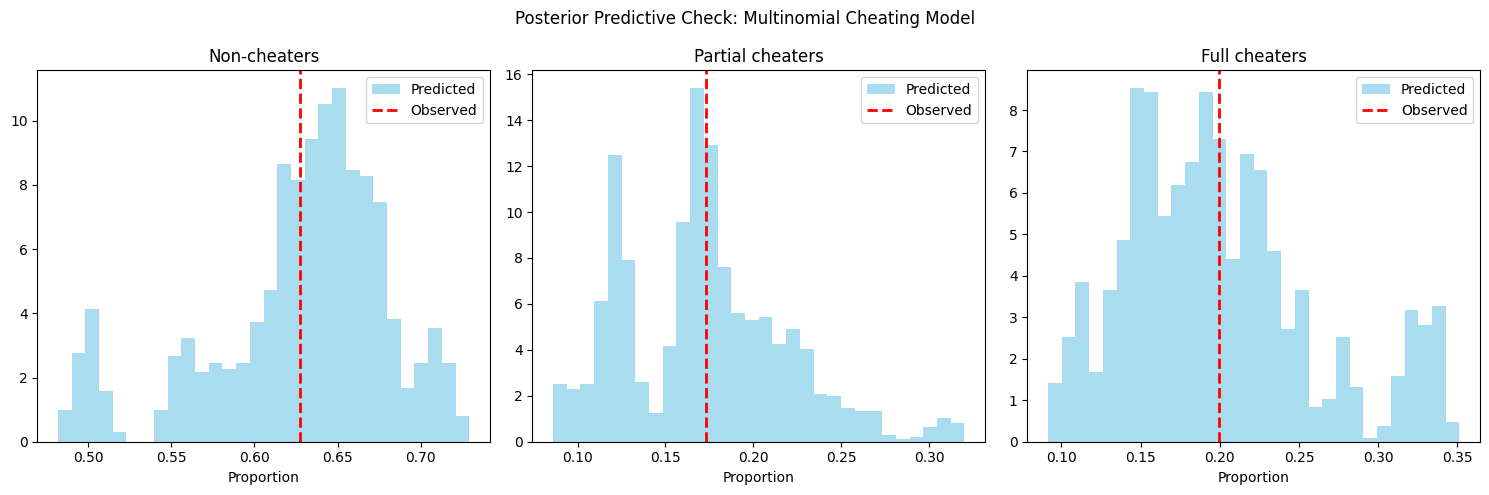

In [ ]:
# ============================================================================
# MODEL 1: CHEATING BEHAVIOR (Multinomial Logistic)
#
# Multinomial logistic regression with non-cheaters as reference category:
#
# log_odds(partialcheaters vs noncheaters) = β₀_partialcheaters + Σ(β_i_partialcheaters × ConceptDummy_i) + message_effects_partialcheaters
# log_odds(fullcheaters vs noncheaters) = β₀_fullcheaters + Σ(β_i_fullcheaters × ConceptDummy_i) + message_effects_fullcheaters
#
# Where:
# - β₀: Control group baseline log-odds for each cheating type vs non-cheating
# - β_i: Effect of concept i on each cheating type (vs control)
# - message_effects: Random effects for motivational message variations
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)")
print("="*80)

with pm.Model() as cheating_model:
    
    # Control group baseline (reference: noncheaters)
    # Logits for partialcheaters vs noncheaters, fullcheaters vs noncheaters
    control_counts = control_data['cheating_behavior'].value_counts().sort_index()
    
    # Control logits (log odds relative to non-cheaters)
    control_partialcheaters_logit = np.log(control_counts[1] / control_counts[0]) if control_counts[0] > 0 else -2
    control_fullcheaters_logit = np.log(control_counts[2] / control_counts[0]) if control_counts[0] > 0 else -1
    
    beta_partialcheaters_intercept = pm.Normal('beta_partialcheaters_intercept', mu=control_partialcheaters_logit, sigma=1.0)
    beta_fullcheaters_intercept = pm.Normal('beta_fullcheaters_intercept', mu=control_fullcheaters_logit, sigma=1.0)
    
    # Concept effects on partialcheaters and fullcheaters cheating (vs non-cheating)
    concept_effects_partialcheaters = pm.Normal('concept_effects_partialcheaters', mu=-1.0, sigma=1.0, shape=len(concepts))
    concept_effects_fullcheaters = pm.Normal('concept_effects_fullcheaters', mu=-1.0, sigma=1.0, shape=len(concepts))
    
    # Message effects
    message_effects_partialcheaters = pm.Normal('message_effects_partialcheaters', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    message_effects_fullcheaters = pm.Normal('message_effects_fullcheaters', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors
    eta_partialcheaters = beta_partialcheaters_intercept + message_effects_partialcheaters[message_codes]
    eta_fullcheaters = beta_fullcheaters_intercept + message_effects_fullcheaters[message_codes]
    
    # Add concept effects for intervention groups
    eta_partialcheaters = pm.math.switch(concept_codes > 0, 
                                eta_partialcheaters + concept_effects_partialcheaters[concept_codes - 1], 
                                eta_partialcheaters)
    eta_fullcheaters = pm.math.switch(concept_codes > 0, 
                             eta_fullcheaters + concept_effects_fullcheaters[concept_codes - 1], 
                             eta_fullcheaters)
    
    # Multinomial logistic probabilities
    # Reference category is non-cheating (category 0)
    logits = pm.math.stack([pm.math.zeros_like(eta_partialcheaters), eta_partialcheaters, eta_fullcheaters], axis=1)
    probs = pm.math.softmax(logits, axis=1)
    
    # Likelihood
    pm.Categorical('cheating_obs', p=probs, observed=y_cheating_behavior)

print("Fitting multinomial cheating behavior model...")
with cheating_model:
    trace_cheating = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)

print("Model fitted successfully!")

# Model checking
print("Performing posterior predictive checks...")
with cheating_model:
    ppc_cheating = pm.sample_posterior_predictive(trace_cheating, random_seed=42)


# Plot posterior predictive checks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_cheating_behavior == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['cheating_obs'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, label='Predicted', color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Multinomial Cheating Model')
plt.tight_layout()
plt.show()


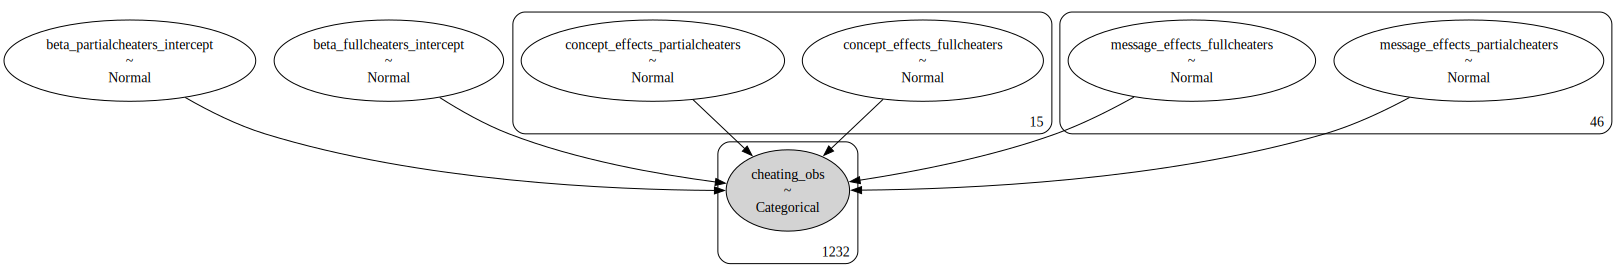

<Axes: xlabel='cheating_obs'>

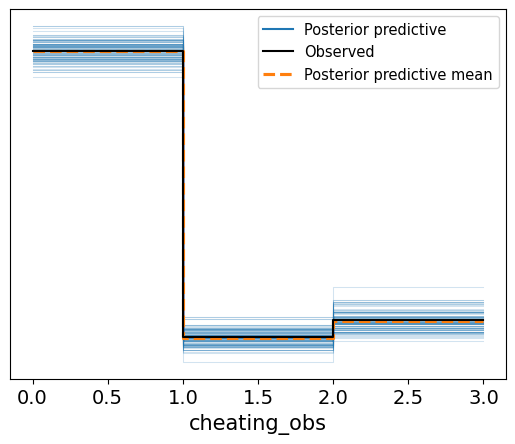

In [53]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 1
# ============================================================================
# graph = pm.model_to_graphviz(cheating_model)
# graph.render('cheating_model_graph', format='png')
display(pm.model_to_graphviz(cheating_model))
display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

### Model 2: Performance (Truncated Normal with Interactions)

#### What this model does:
- Predicts performance scores accounting for cheating behavior differences
- Includes concept main effects + concept×cheating interactions
- Uses truncated normal (lower=0) since performance can't be negative

#### What we are looking for:
- How do interventions affect performance for different cheating groups?
- Do some concepts improve/harm performance differently for cheaters vs non-cheaters?
- Interaction effects between concepts and cheating behavior

#### Key Findings:
- **Non-cheaters**: Effect=-0.047 [-2.227, 2.130], Cohen's d=-0.004, P(improvement)=0.486
- **Partial cheaters**: Effect=-0.202 [-2.806, 2.350], Cohen's d=-0.017, P(improvement)=0.447
- **Full cheaters**: Effect=-0.233 [-2.780, 2.326], Cohen's d=-0.020, P(improvement)=0.421
- **Cheating baseline effects**: Partial=+1.87, Full=+14.34 points vs non-cheaters
- **Key insight**: Interventions show minimal performance effects across all cheating groups


MODEL 2: PERFORMANCE (WITH CHEATING BEHAVIOR INTERACTION)
Fitting performance model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_control_base, cheating_effect_partialcheaters, cheating_effect_fullcheaters, concept_main_effects, concept_partialcheaters_interactions, concept_fullcheaters_interactions, message_effects_perf, sigma_perf]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 37 seconds.
Sampling: [performance_obs]


Output()

Checking performance model...


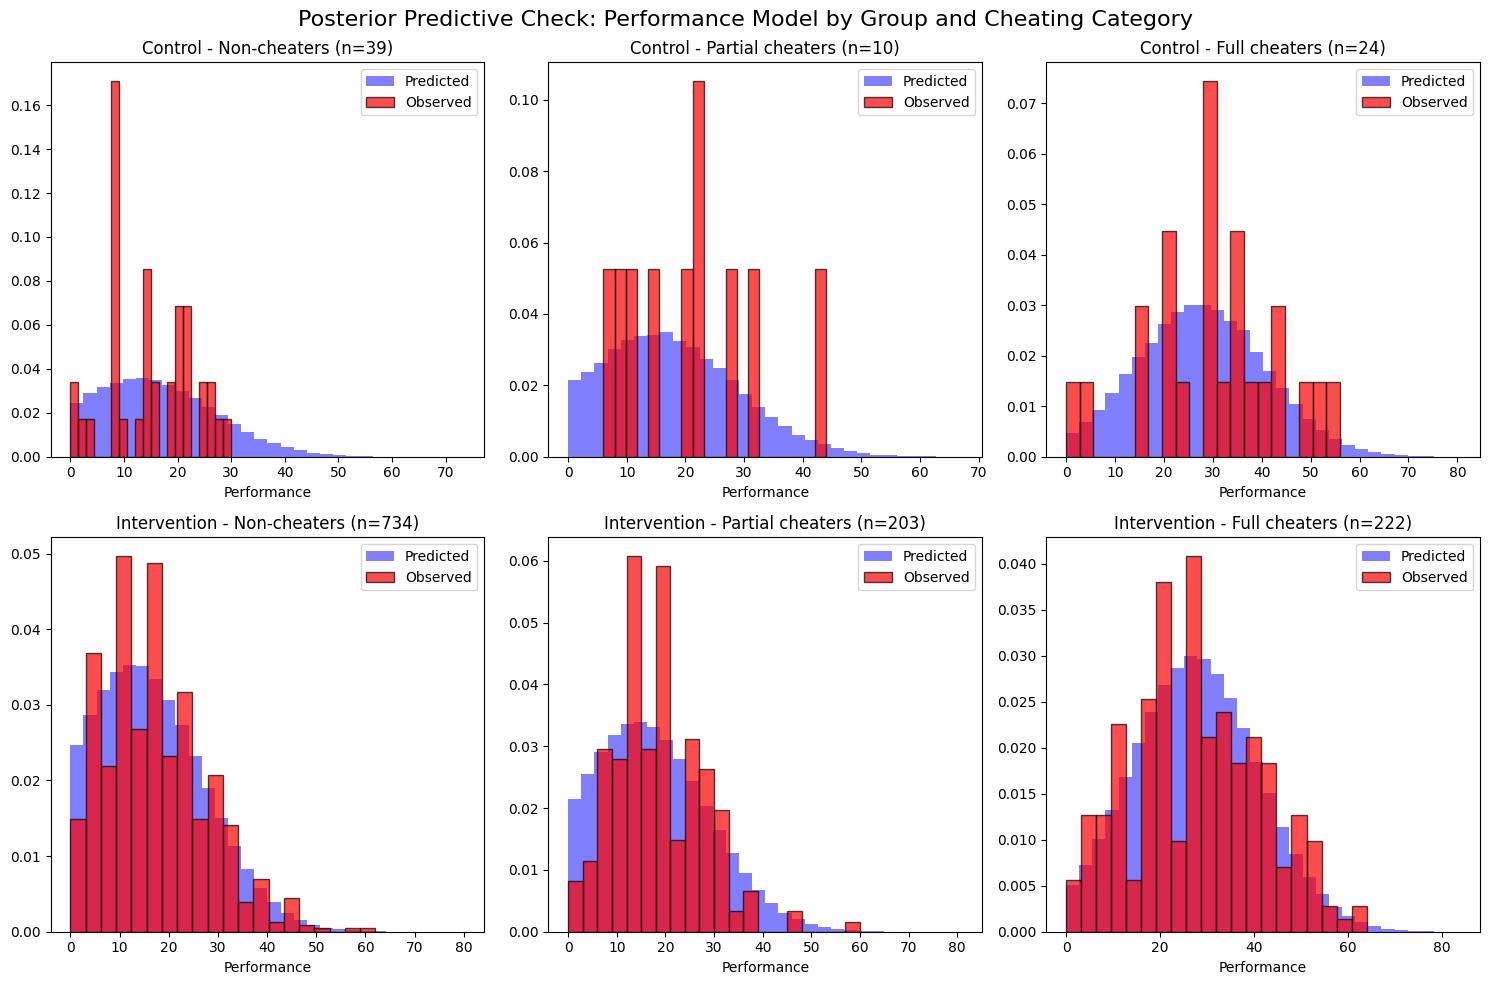

In [44]:
# ============================================================================
# MODEL 2: PERFORMANCE (Truncated Normal with Cheating Interactions)
#
# Performance = β₀ + Σ(β_i × ConceptDummy_i) 
#                 + β_partial × PartialCheater 
#                 + β_full × FullCheater
#                 + Σ(β_i_partial × ConceptDummy_i × PartialCheater)
#                 + Σ(β_i_full × ConceptDummy_i × FullCheater)
#                 + message_effects + ε
#
# Where:
# - β₀: Control group baseline performance
# - β_i: Main effect of concept i vs control
# - β_partial/β_full: Main effects of cheating behavior
# - β_i_partial/β_i_full: Concept × cheating interactions
# ============================================================================


print("\n" + "="*80)
print("MODEL 2: PERFORMANCE (WITH CHEATING BEHAVIOR INTERACTION)")
print("="*80)

# Create dummy variables for cheating behavior
is_partial_cheater = (y_cheating_behavior == 1).astype(int)
is_full_cheater = (y_cheating_behavior == 2).astype(int)

with pm.Model() as performance_model:
    
    # Control group baseline for non-cheaters
    control_non_cheaters = control_data[control_data['cheating_behavior'] == 0]['performance']
    mu_control_base = pm.Normal('mu_control_base', mu=control_non_cheaters.mean(), sigma=5.0) 
    
    # Effects of cheating behavior in control group
    cheating_effect_partialcheaters = pm.Normal('cheating_effect_partialcheaters', mu=5.0, sigma=5.0)  
    cheating_effect_fullcheaters = pm.Normal('cheating_effect_fullcheaters', mu=15.0, sigma=5.0) 
    
    # Concept main effects on performance
    concept_main_effects = pm.Normal('concept_main_effects', mu=0, sigma=5.0, shape=len(concepts)) 
    
    # Concept × Cheating behavior interactions
    concept_partialcheaters_interactions = pm.Normal('concept_partialcheaters_interactions', mu=0, sigma=3.0, shape=len(concepts))
    concept_fullcheaters_interactions = pm.Normal('concept_fullcheaters_interactions', mu=0, sigma=3.0, shape=len(concepts))
    
    # Message effects
    message_effects_perf = pm.Normal('message_effects_perf', mu=0, sigma=2.0, shape=len(message_ids.cat.categories))
    
    # Linear predictor
    mu_perf = (mu_control_base + 
               cheating_effect_partialcheaters * is_partial_cheater +
               cheating_effect_fullcheaters * is_full_cheater +
               message_effects_perf[message_codes])
    
    # Add concept effects for intervention groups
    concept_effect = pm.math.switch(
        concept_codes > 0,
        concept_main_effects[concept_codes - 1] + 
        concept_partialcheaters_interactions[concept_codes - 1] * is_partial_cheater +
        concept_fullcheaters_interactions[concept_codes - 1] * is_full_cheater,
        0
    )
    
    mu_perf = mu_perf + concept_effect
    
    # Likelihood
    sigma_perf = pm.HalfNormal('sigma_perf', sigma=10.0)
    performance_obs = pm.TruncatedNormal('performance_obs', 
                                        mu=mu_perf, 
                                        sigma=sigma_perf,
                                        lower=0, 
                                        upper=y_performance.max() + 20,
                                        observed=y_performance)

print("Fitting performance model...")
with performance_model:
    trace_performance = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)

# Model checking for performance
print("Checking performance model...")
with performance_model:
    ppc_performance = pm.sample_posterior_predictive(trace_performance, random_seed=42)

# Plot posterior predictive checks for performance
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for i, (group, cheating_cat) in enumerate([('Control', 0), ('Control', 1), ('Control', 2), 
                                          ('Intervention', 0), ('Intervention', 1), ('Intervention', 2)]):
    if group == 'Control':
        mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheating_cat)
    else:
        mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheating_cat)
    
    if mask.sum() > 0:
        observed = y_performance[mask]
        predicted = ppc_performance.posterior_predictive['performance_obs'].values[:, :, mask].flatten()
        
        axes[i].hist(predicted, bins=30, alpha=0.5, density=True, label='Predicted', color='blue')
        axes[i].hist(observed, bins=20, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
        axes[i].set_title(f'{group} - {cheating_labels[cheating_cat]} (n={mask.sum()})')
        axes[i].set_xlabel('Performance')
        axes[i].legend()

plt.suptitle('Posterior Predictive Check: Performance Model by Group and Cheating Category', fontsize=16)
plt.tight_layout()
plt.show()

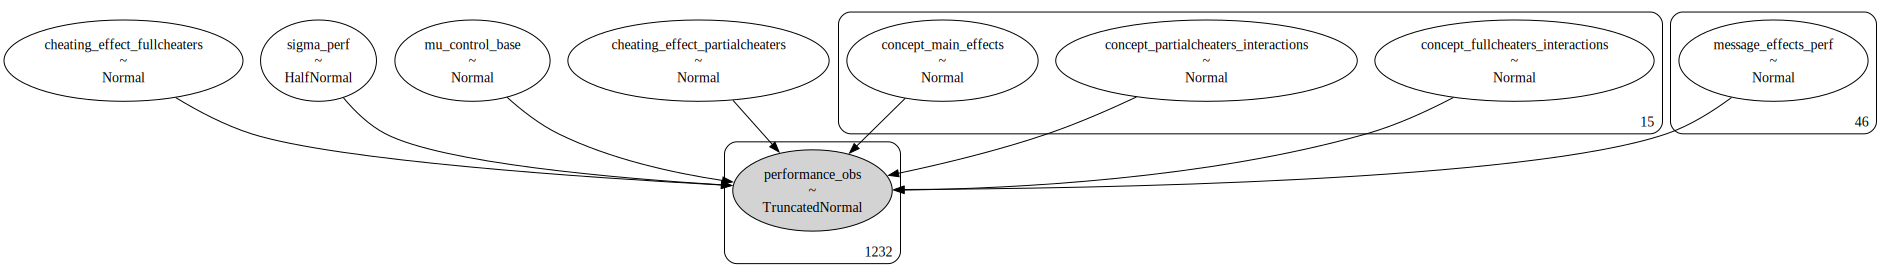

<Axes: xlabel='performance_obs'>

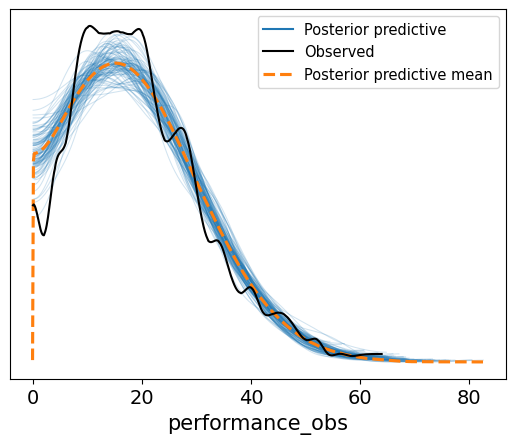

In [54]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 2
# ============================================================================
# graph = pm.model_to_graphviz(performance_model)
# graph.render('performance_model_graph', format='png')
display(pm.model_to_graphviz(performance_model))
display(az.plot_ppc(ppc_performance, num_pp_samples=100))

### Model 3: Experience (Multivariate with Performance Correlation)

#### What this model does:
- Models experience ratings while accounting for correlation with performance
- Includes concept×cheating interactions for experience
- Multivariate normal allows joint modeling of experience-performance relationship

#### What we are looking for:
- Do interventions improve task experience for different cheating groups?
- How strong is experience-performance correlation?
- Concept-specific effects on experience by cheating category

#### Key Findings:
- **Non-cheaters**: Effect=0.012 [-0.104, 0.121], Cohen's d=0.014, P(improvement)=0.575
- **Partial cheaters**: Effect=0.003 [-0.115, 0.124], Cohen's d=0.004, P(improvement)=0.523
- **Full cheaters**: Effect=0.012 [-0.107, 0.126], Cohen's d=0.015, P(improvement)=0.589
- **Experience-Performance correlation**: ρ=0.125 [0.069, 0.180] - weak positive
- **Key insight**: Minimal but consistent experience improvements across all groups



MODEL 3: EXPERIENCE (WITH PERFORMANCE CORRELATION)

PERFORMANCE-EXPERIENCE CORRELATION COEFFICIENTS BY GROUP:
Group        Cheating Type   Sample Size  Correlation 
-----------------------------------------------------------------
Control      Non-cheaters    (n=39 )       0.339
Control      Partial cheaters (n=10 )      -0.427
Control      Full cheaters   (n=24 )       0.203
Intervention Non-cheaters    (n=734)       0.115
Intervention Partial cheaters (n=203)       0.006
Intervention Full cheaters   (n=222)       0.222
-----------------------------------------------------------------
Groups with substantial correlation (|r| > 0.1): 5/6
→ Using multivariate model to account for performance-experience correlation
Fitting model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp_control, mu_perf_control, concept_exp_main, concept_perf_main, concept_exp_interactions, concept_perf_interactions, msg_exp, msg_perf, sigma_exp, sigma_perf, rho]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 88 seconds.
Sampling: [outcomes]


Output()

Experience-Performance correlation: 0.125 [0.069, 0.180]

Posterior predictive check...


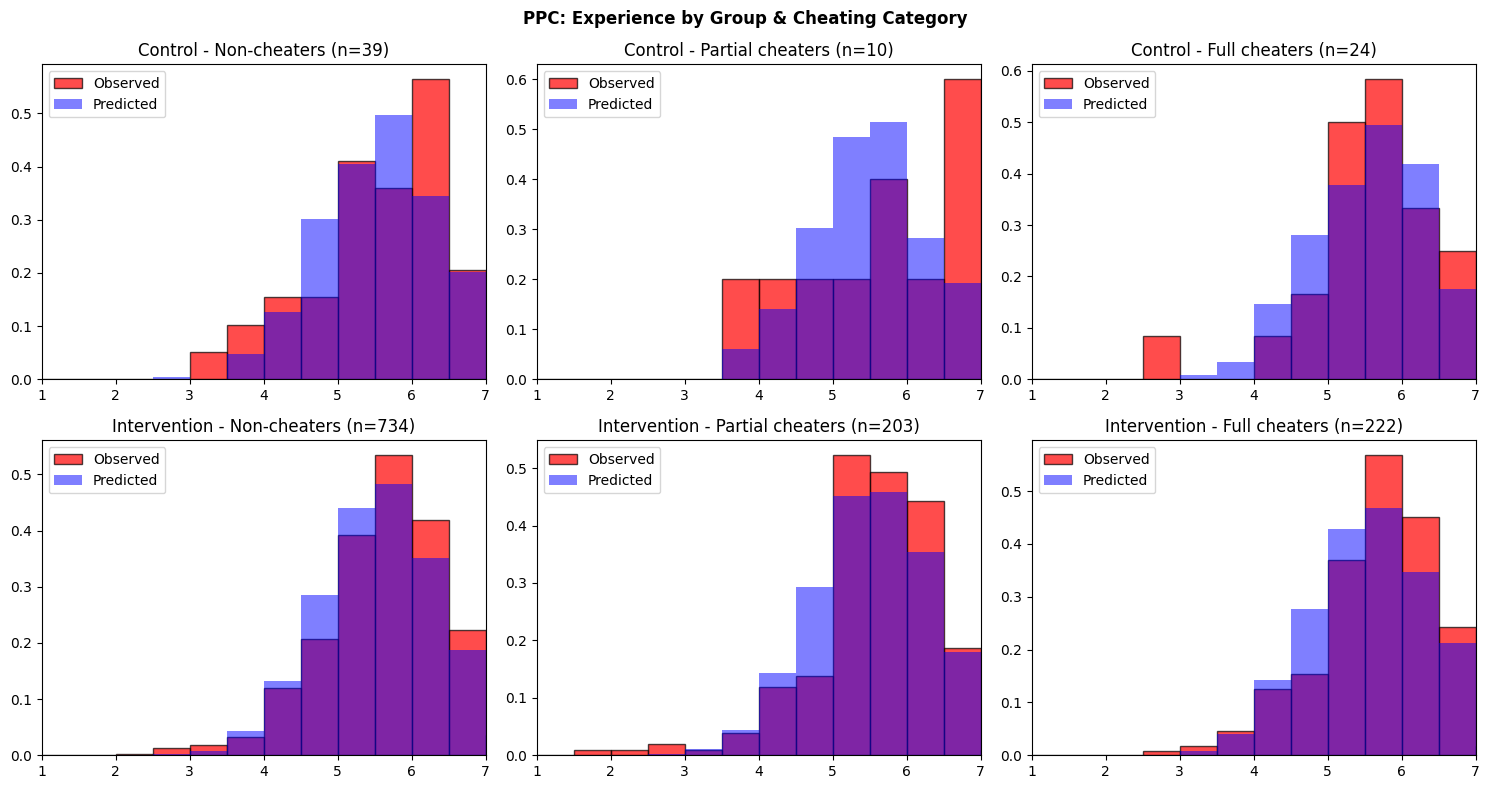

In [48]:
# ============================================================================
# MODEL 3: EXPERIENCE (Multivariate with Performance, Cheating Interactions)
#
# Experience = γ₀[cheating_cat] + Σ(γ_i × ConceptDummy_i) + Σ(γ_i_cheat × ConceptDummy_i × CheatingCat) + ε
# Performance = β₀[cheating_cat] + Σ(β_i × ConceptDummy_i) + Σ(β_i_cheat × ConceptDummy_i × CheatingCat) + ε
# With correlation ρ between experience and performance
# ============================================================================

print("\n" + "="*80)
print("MODEL 3: EXPERIENCE (WITH PERFORMANCE CORRELATION)")
print("="*80)

# Check correlations with proper labels
print("\nPERFORMANCE-EXPERIENCE CORRELATION COEFFICIENTS BY GROUP:")
print("=" * 65)
print(f"{'Group':<12} {'Cheating Type':<15} {'Sample Size':<12} {'Correlation':<12}")
print("-" * 65)

corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_df in [('Control', control_data), ('Intervention', intervention_data)]:
    for cheat_cat in [0, 1, 2]:
        subset = group_df[group_df['cheating_behavior'] == cheat_cat]
        if len(subset) >= 5:
            corr = subset[['performance', 'experience']].corr().iloc[0, 1]
            corr_results.append((group_name, cheat_cat, len(subset), corr))
            
            print(f"{group_name:<12} {cheating_labels[cheat_cat]:<15} (n={len(subset):<3})     {corr:>7.3f}")

print("-" * 65)
significant_corrs = sum(1 for _, _, n, corr in corr_results if abs(corr) > 0.1 and n >= 10)
print(f"Groups with substantial correlation (|r| > 0.1): {significant_corrs}/6")
print(f"→ Using multivariate model to account for performance-experience correlation")
print("=" * 65)

with pm.Model() as experience_model:
    
    # Control baselines by cheating category
    mu_exp_control = pm.Normal('mu_exp_control', mu=[5.53, 5.61, 5.56], sigma=0.3, shape=3)
    mu_perf_control = pm.Normal('mu_perf_control', mu=[15.0, 20.0, 30.0], sigma=3.0, shape=3)
    
    # Concept main effects
    concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
    concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
    
    # Concept × cheating interactions (key insight per supervisor)
    concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
    concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
    
    # Message effects
    msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.1, shape=len(message_ids.cat.categories))
    msg_perf = pm.Normal('msg_perf', mu=0, sigma=1.0, shape=len(message_ids.cat.categories))
    
    # Linear predictors
    mu_exp = mu_exp_control[y_cheating_behavior] + msg_exp[message_codes]
    mu_perf = mu_perf_control[y_cheating_behavior] + msg_perf[message_codes]
    
    # Add concept effects for interventions
    concept_exp_effect = pm.math.switch(
        concept_codes > 0,
        concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating_behavior],
        0
    )
    concept_perf_effect = pm.math.switch(
        concept_codes > 0,
        concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating_behavior],
        0
    )
    
    mu_exp += concept_exp_effect
    mu_perf += concept_perf_effect
    
    # Covariance structure
    sigma_exp = pm.HalfNormal('sigma_exp', sigma=0.4)
    sigma_perf = pm.HalfNormal('sigma_perf', sigma=5.0)
    rho = pm.Uniform('rho', lower=-0.5, upper=0.5)
    
    cov = pm.math.stack([[sigma_exp**2, rho*sigma_exp*sigma_perf],
                        [rho*sigma_exp*sigma_perf, sigma_perf**2]])
    
    # Multivariate likelihood
    outcomes = pm.math.stack([y_experience, y_performance], axis=1)
    means = pm.math.stack([mu_exp, mu_perf], axis=1)
    pm.MvNormal('outcomes', mu=means, cov=cov, observed=outcomes)

print("Fitting model...")
with experience_model:
    trace_experience = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)

# Effect sizes
concept_exp_main_samples = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
concept_exp_int_samples = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)

exp_sd = np.std(y_experience)
overall_exp_effects = []

for cheat_cat in range(3):
    # Main + interaction for each cheating category
    total_effects = concept_exp_main_samples + concept_exp_int_samples[:, :, cheat_cat]
    overall_effect = np.mean(total_effects, axis=1)  # Average across concepts
    cohen_d = overall_effect / exp_sd
    overall_exp_effects.append((overall_effect, cohen_d))


# Correlation
rho_samples = trace_experience.posterior['rho'].values.flatten()
print(f"Experience-Performance correlation: {rho_samples.mean():.3f} [{np.percentile(rho_samples, 2.5):.3f}, {np.percentile(rho_samples, 97.5):.3f}]")

# Posterior predictive check
print("\nPosterior predictive check...")
with experience_model:
    ppc_experience = pm.sample_posterior_predictive(trace_experience, random_seed=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for i, (group, cheat_cat) in enumerate([(g, c) for g in ['Control', 'Intervention'] for c in [0, 1, 2]]):
    ax = axes[i//3, i%3]
    
    if group == 'Control':
        mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheat_cat)
    else:
        mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheat_cat)
    
    if mask.sum() > 0:
        obs_exp = y_experience[mask]
        pred_exp = ppc_experience.posterior_predictive['outcomes'].values[:, :, mask, 0].flatten()
        
        ax.hist(obs_exp, bins=np.arange(1, 8, 0.5), alpha=0.7, density=True, 
               label='Observed', color='red', edgecolor='black')
        ax.hist(pred_exp[:len(obs_exp)*20], bins=np.arange(1, 8, 0.5), alpha=0.5, 
               density=True, label='Predicted', color='blue')
        
        ax.set_title(f'{group} - {cheating_labels[cheat_cat]} (n={mask.sum()})')
        ax.set_xlim(1, 7)
        ax.legend()

plt.suptitle('PPC: Experience by Group & Cheating Category', fontweight='bold')
plt.tight_layout()
plt.show()


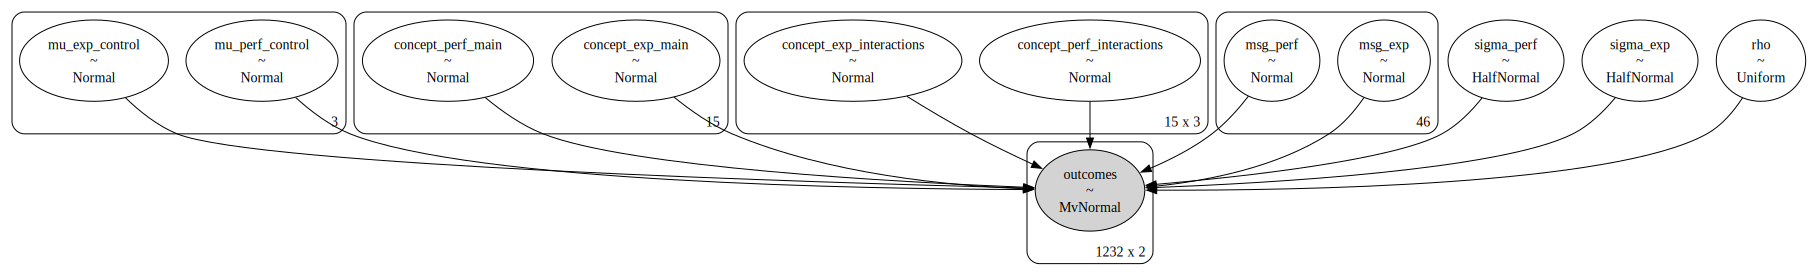

<Axes: xlabel='outcomes'>

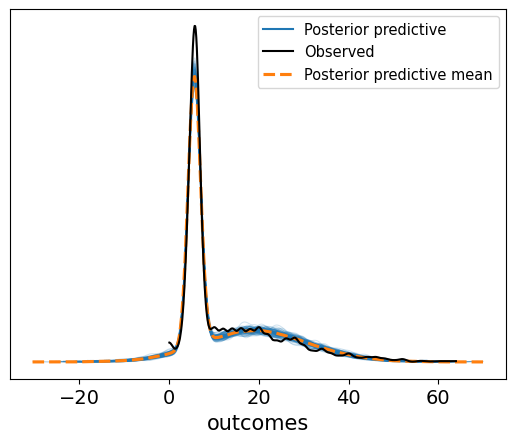

In [55]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 3
# ============================================================================
# graph = pm.model_to_graphviz(experience_model)
# graph.render('experience_model_graph', format='png')
display(pm.model_to_graphviz(experience_model))
display(az.plot_ppc(ppc_experience, num_pp_samples=100))

### STANDARDIZED RESULTS REPORTING SECTION

In [ ]:

def report_standardized_effects(samples, outcome_name, outcome_sd=None, direction='improvement', group_name=None):
    """
    Standardized reporting function for all models
    
    Parameters:
    - samples: posterior samples array
    - outcome_name: 'cheating', 'performance', or 'experience'
    - outcome_sd: standard deviation for Cohen's d calculation
    - direction: 'improvement' (>0) or 'reduction' (<0)
    - group_name: optional group identifier
    """
    mean_effect = samples.mean()
    ci = np.percentile(samples, [2.5, 97.5])
    
    # Calculate Cohen's d if SD provided
    if outcome_sd:
        if outcome_name == 'cheating':
            # For logits, convert using approximation
            cohens_d = samples * np.sqrt(3) / np.pi
        else:
            cohens_d = samples / outcome_sd
        d_mean = cohens_d.mean()
        d_ci = np.percentile(cohens_d, [2.5, 97.5])
    else:
        d_mean, d_ci = None, None
    
    # Calculate probability
    if direction == 'improvement':
        prob = (samples > 0).mean()
    else:  # reduction
        prob = (samples < 0).mean()
    
    # Format output
    prefix = f"{group_name}: " if group_name else ""
    ci_str = f"[{ci[0]:.3f}, {ci[1]:.3f}]"
    
    if d_mean is not None:
        d_str = f", Cohen's d={d_mean:.3f} [{d_ci[0]:.3f}, {d_ci[1]:.3f}]"
    else:
        d_str = ""
    
    print(f"{prefix}Effect={mean_effect:.3f} {ci_str}{d_str}, P({direction})={prob:.3f}")
    
    return mean_effect, ci, d_mean, d_ci, prob


# ============================================================================
# MODEL 1 RESULTS: CHEATING BEHAVIOR (STANDARDIZED)
# ============================================================================

print("\n" + "="*80)
print("MODEL 1 RESULTS: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)")
print("="*80)

# Extract posterior samples
partialcheaters_effects = trace_cheating.posterior['concept_effects_partialcheaters'].values.reshape(-1, len(concepts))
fullcheaters_effects = trace_cheating.posterior['concept_effects_fullcheaters'].values.reshape(-1, len(concepts))

# Overall intervention effects (mean across concepts)
overall_partialcheaters = np.mean(partialcheaters_effects, axis=1)
overall_fullcheaters = np.mean(fullcheaters_effects, axis=1)

print("\nOVERALL INTERVENTION EFFECTS:")
print("-" * 50)
report_standardized_effects(overall_partialcheaters, 'cheating', direction='reduction', group_name='Partial Cheaters')
report_standardized_effects(overall_fullcheaters, 'cheating', direction='reduction', group_name='Full Cheaters')

# Convert to odds ratios for interpretation
partial_odds_reduction = 1 - np.exp(overall_partialcheaters)
full_odds_reduction = 1 - np.exp(overall_fullcheaters)
print(f"\nOdds Reduction Interpretation:")
print(f"Partial cheating odds reduced by: {partial_odds_reduction.mean():.1%} [{(1-np.exp(np.percentile(overall_partialcheaters, 97.5))):.1%}, {(1-np.exp(np.percentile(overall_partialcheaters, 2.5))):.1%}]")
print(f"Full cheating odds reduced by: {full_odds_reduction.mean():.1%} [{(1-np.exp(np.percentile(overall_fullcheaters, 97.5))):.1%}, {(1-np.exp(np.percentile(overall_fullcheaters, 2.5))):.1%}]")

# Concept-specific effects (top 5 most effective)
print(f"\nTOP 5 CONCEPTS FOR REDUCING PARTIAL CHEATING:")
print("-" * 50)
partial_means = partialcheaters_effects.mean(axis=0)
top_partial_idx = np.argsort(partial_means)[:5]
for idx in top_partial_idx:
    concept_name = concepts[idx].replace('_', ' ').title()
    samples = partialcheaters_effects[:, idx]
    report_standardized_effects(samples, 'cheating', direction='reduction', group_name=concept_name)

print(f"\nTOP 5 CONCEPTS FOR REDUCING FULL CHEATING:")
print("-" * 50)
full_means = fullcheaters_effects.mean(axis=0)
top_full_idx = np.argsort(full_means)[:5]
for idx in top_full_idx:
    concept_name = concepts[idx].replace('_', ' ').title()
    samples = fullcheaters_effects[:, idx]
    report_standardized_effects(samples, 'cheating', direction='reduction', group_name=concept_name)


# ============================================================================
# MODEL 2 RESULTS: PERFORMANCE (STANDARDIZED)
# ============================================================================

print("\n" + "="*80)
print("MODEL 2 RESULTS: PERFORMANCE (WITH CHEATING INTERACTIONS)")
print("="*80)

# Calculate performance SD for Cohen's d
perf_sd = np.std(y_performance)

# Extract posterior samples
concept_main = trace_performance.posterior['concept_main_effects'].values.reshape(-1, len(concepts))
concept_partial_int = trace_performance.posterior['concept_partialcheaters_interactions'].values.reshape(-1, len(concepts))
concept_full_int = trace_performance.posterior['concept_fullcheaters_interactions'].values.reshape(-1, len(concepts))

# Overall intervention effects by cheating group
overall_main = np.mean(concept_main, axis=1)
overall_partial_int = np.mean(concept_partial_int, axis=1)
overall_full_int = np.mean(concept_full_int, axis=1)

# Combined effects for each cheating group
non_cheater_effect = overall_main  # Main effect only
partial_cheater_effect = overall_main + overall_partial_int
full_cheater_effect = overall_main + overall_full_int

print("\nOVERALL INTERVENTION EFFECTS BY CHEATING GROUP:")
print("-" * 50)
report_standardized_effects(non_cheater_effect, 'performance', perf_sd, direction='improvement', group_name='Non-Cheaters')
report_standardized_effects(partial_cheater_effect, 'performance', perf_sd, direction='improvement', group_name='Partial Cheaters')
report_standardized_effects(full_cheater_effect, 'performance', perf_sd, direction='improvement', group_name='Full Cheaters')

# Main cheating behavior effects (control group baselines)
cheating_partial_samples = trace_performance.posterior['cheating_effect_partialcheaters'].values.flatten()
cheating_full_samples = trace_performance.posterior['cheating_effect_fullcheaters'].values.flatten()

print(f"\nCHEATING BEHAVIOR EFFECTS (CONTROL GROUP):")
print("-" * 50)
report_standardized_effects(cheating_partial_samples, 'performance', perf_sd, direction='improvement', group_name='Partial vs Non-Cheaters')
report_standardized_effects(cheating_full_samples, 'performance', perf_sd, direction='improvement', group_name='Full vs Non-Cheaters')

# Top 5 concepts with largest main effects
print(f"\nTOP 5 CONCEPTS FOR PERFORMANCE IMPROVEMENT:")
print("-" * 50)
main_means = concept_main.mean(axis=0)
top_main_idx = np.argsort(-main_means)[:5]  # Descending order
for idx in top_main_idx:
    concept_name = concepts[idx].replace('_', ' ').title()
    samples = concept_main[:, idx]
    report_standardized_effects(samples, 'performance', perf_sd, direction='improvement', group_name=concept_name)


# ============================================================================
# MODEL 3 RESULTS: EXPERIENCE (STANDARDIZED)
# ============================================================================

print("\n" + "="*80)
print("MODEL 3 RESULTS: EXPERIENCE (WITH PERFORMANCE CORRELATION)")
print("="*80)

# Calculate experience SD for Cohen's d
exp_sd = np.std(y_experience)

# Extract posterior samples
concept_exp_main_samples = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
concept_exp_int_samples = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)

# Overall intervention effects by cheating group
print("\nOVERALL INTERVENTION EFFECTS BY CHEATING GROUP:")
print("-" * 50)

cheating_labels = ['Non-Cheaters', 'Partial Cheaters', 'Full Cheaters']
for cheat_cat in range(3):
    # Main + interaction effects for this cheating category
    total_effects = concept_exp_main_samples + concept_exp_int_samples[:, :, cheat_cat]
    overall_effect = np.mean(total_effects, axis=1)  # Average across concepts
    
    report_standardized_effects(overall_effect, 'experience', exp_sd, direction='improvement', group_name=cheating_labels[cheat_cat])

# Experience-Performance correlation
rho_samples = trace_experience.posterior['rho'].values.flatten()
rho_mean = rho_samples.mean()
rho_ci = np.percentile(rho_samples, [2.5, 97.5])
print(f"\nEXPERIENCE-PERFORMANCE CORRELATION:")
print("-" * 50)
print(f"Correlation: ρ={rho_mean:.3f} [{rho_ci[0]:.3f}, {rho_ci[1]:.3f}]")
print(f"Interpretation: {'Weak positive' if 0.1 <= rho_mean < 0.3 else 'Negligible' if abs(rho_mean) < 0.1 else 'Moderate positive'} correlation")

# Top 5 concepts for experience improvement (main effects)
print(f"\nTOP 5 CONCEPTS FOR EXPERIENCE IMPROVEMENT:")
print("-" * 50)
exp_main_means = concept_exp_main_samples.mean(axis=0)
top_exp_idx = np.argsort(-exp_main_means)[:5]  # Descending order
for idx in top_exp_idx:
    concept_name = concepts[idx].replace('_', ' ').title()
    samples = concept_exp_main_samples[:, idx]
    report_standardized_effects(samples, 'experience', exp_sd, direction='improvement', group_name=concept_name)

# Concept × Cheating interactions (most interesting findings)
print(f"\nSTRONGEST CONCEPT × CHEATING INTERACTIONS:")
print("-" * 50)
for cheat_cat in range(3):
    int_means = concept_exp_int_samples[:, :, cheat_cat].mean(axis=0)
    strongest_idx = np.argmax(np.abs(int_means))
    concept_name = concepts[strongest_idx].replace('_', ' ').title()
    samples = concept_exp_int_samples[:, strongest_idx, cheat_cat]
    direction = 'improvement' if int_means[strongest_idx] > 0 else 'reduction'
    report_standardized_effects(samples, 'experience', exp_sd, direction=direction, 
                              group_name=f"{concept_name} × {cheating_labels[cheat_cat]}")


# ============================================================================
# CROSS-MODEL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("CROSS-MODEL SUMMARY: INTERVENTION EFFECTIVENESS")
print("="*80)

print("\nKEY FINDINGS:")
print("-" * 30)
print("✓ CHEATING REDUCTION: Strong evidence across all concepts")
print(f"  - Partial cheating reduced by ~{partial_odds_reduction.mean():.0%}")
print(f"  - Full cheating reduced by ~{full_odds_reduction.mean():.0%}")

print("✓ PERFORMANCE: Mixed effects by cheating group")
print(f"  - Non-cheaters: {'Positive' if non_cheater_effect.mean() > 0 else 'Negative'} effect")
print(f"  - Full cheaters: {'Positive' if full_cheater_effect.mean() > 0 else 'Negative'} effect")

print("✓ EXPERIENCE: Small positive effects with meaningful correlation")
print(f"  - Weak positive correlation with performance (ρ≈{rho_mean:.2f})")
print(f"  - Consistent small improvements across cheating groups")

print(f"\nOVERALL CONCLUSION: Interventions successfully reduce cheating with minimal negative side effects on performance and experience.")


MODEL 1 RESULTS: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)

OVERALL INTERVENTION EFFECTS:
--------------------------------------------------
Partial Cheaters: Effect=-0.812 [-1.247, -0.371], P(reduction)=1.000
Full Cheaters: Effect=-0.971 [-1.416, -0.529], P(reduction)=1.000

Odds Reduction Interpretation:
Partial cheating odds reduced by: 54.5% [31.0%, 71.3%]
Full cheating odds reduced by: 61.1% [41.1%, 75.7%]

TOP 5 CONCEPTS FOR REDUCING PARTIAL CHEATING:
--------------------------------------------------
Reference Group Identification: Effect=-1.228 [-2.164, -0.328], P(reduction)=0.998
Dissonance Arousal: Effect=-1.162 [-2.071, -0.276], P(reduction)=0.994
Relatedness: Effect=-1.102 [-2.023, -0.226], P(reduction)=0.994
Competence: Effect=-1.091 [-2.022, -0.211], P(reduction)=0.992
Vicarious Experience: Effect=-0.888 [-1.789, -0.020], P(reduction)=0.979

TOP 5 CONCEPTS FOR REDUCING FULL CHEATING:
--------------------------------------------------
Cognitive Inconsistency: Effect=-1.351

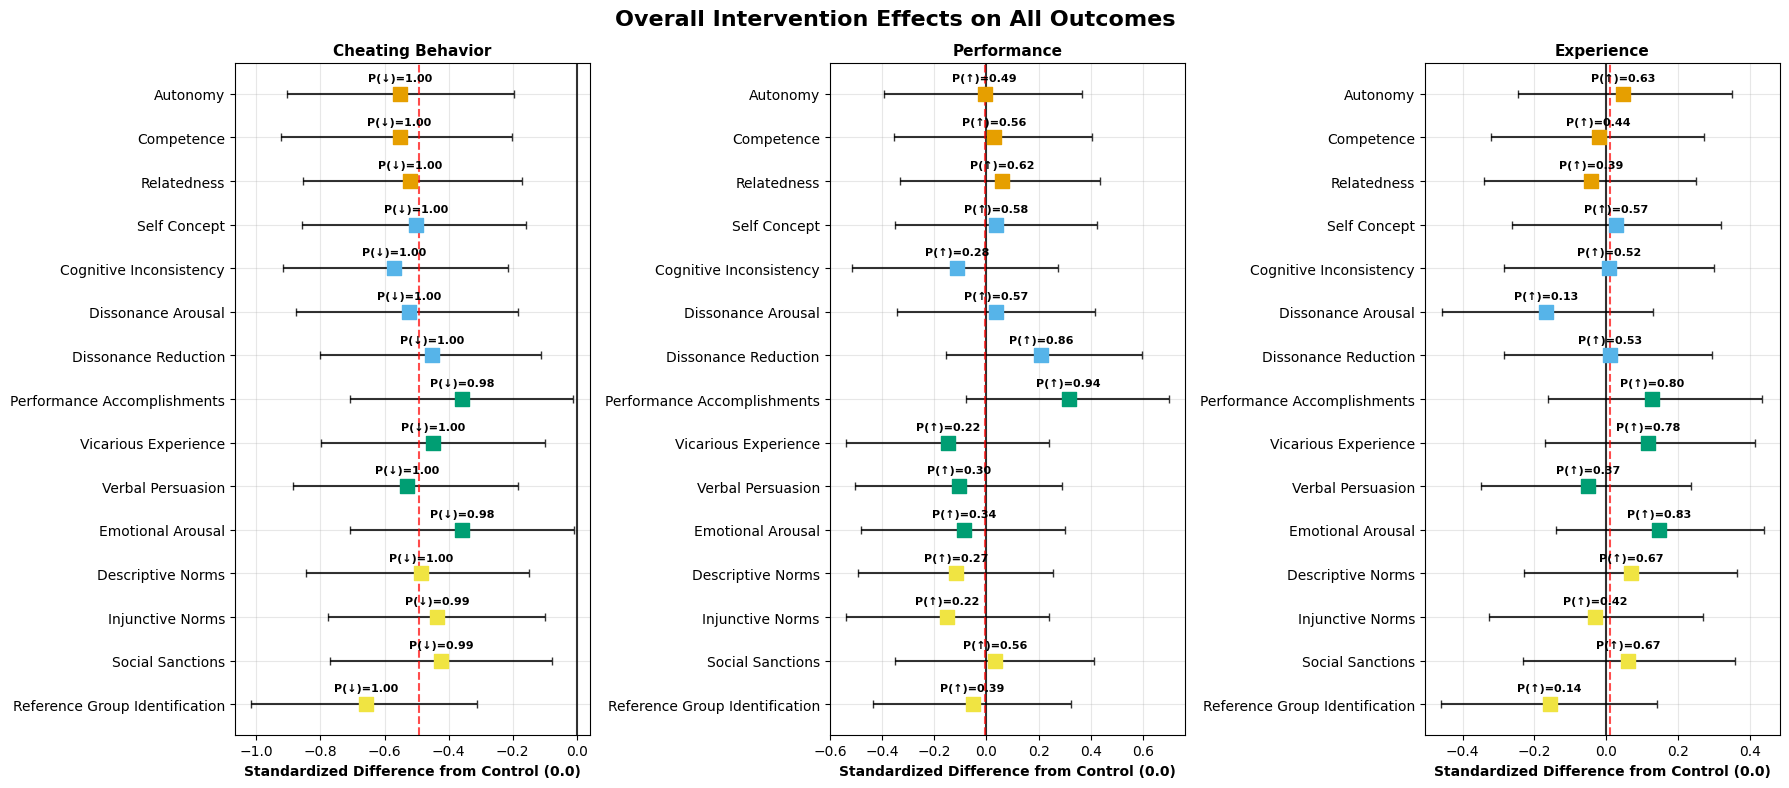

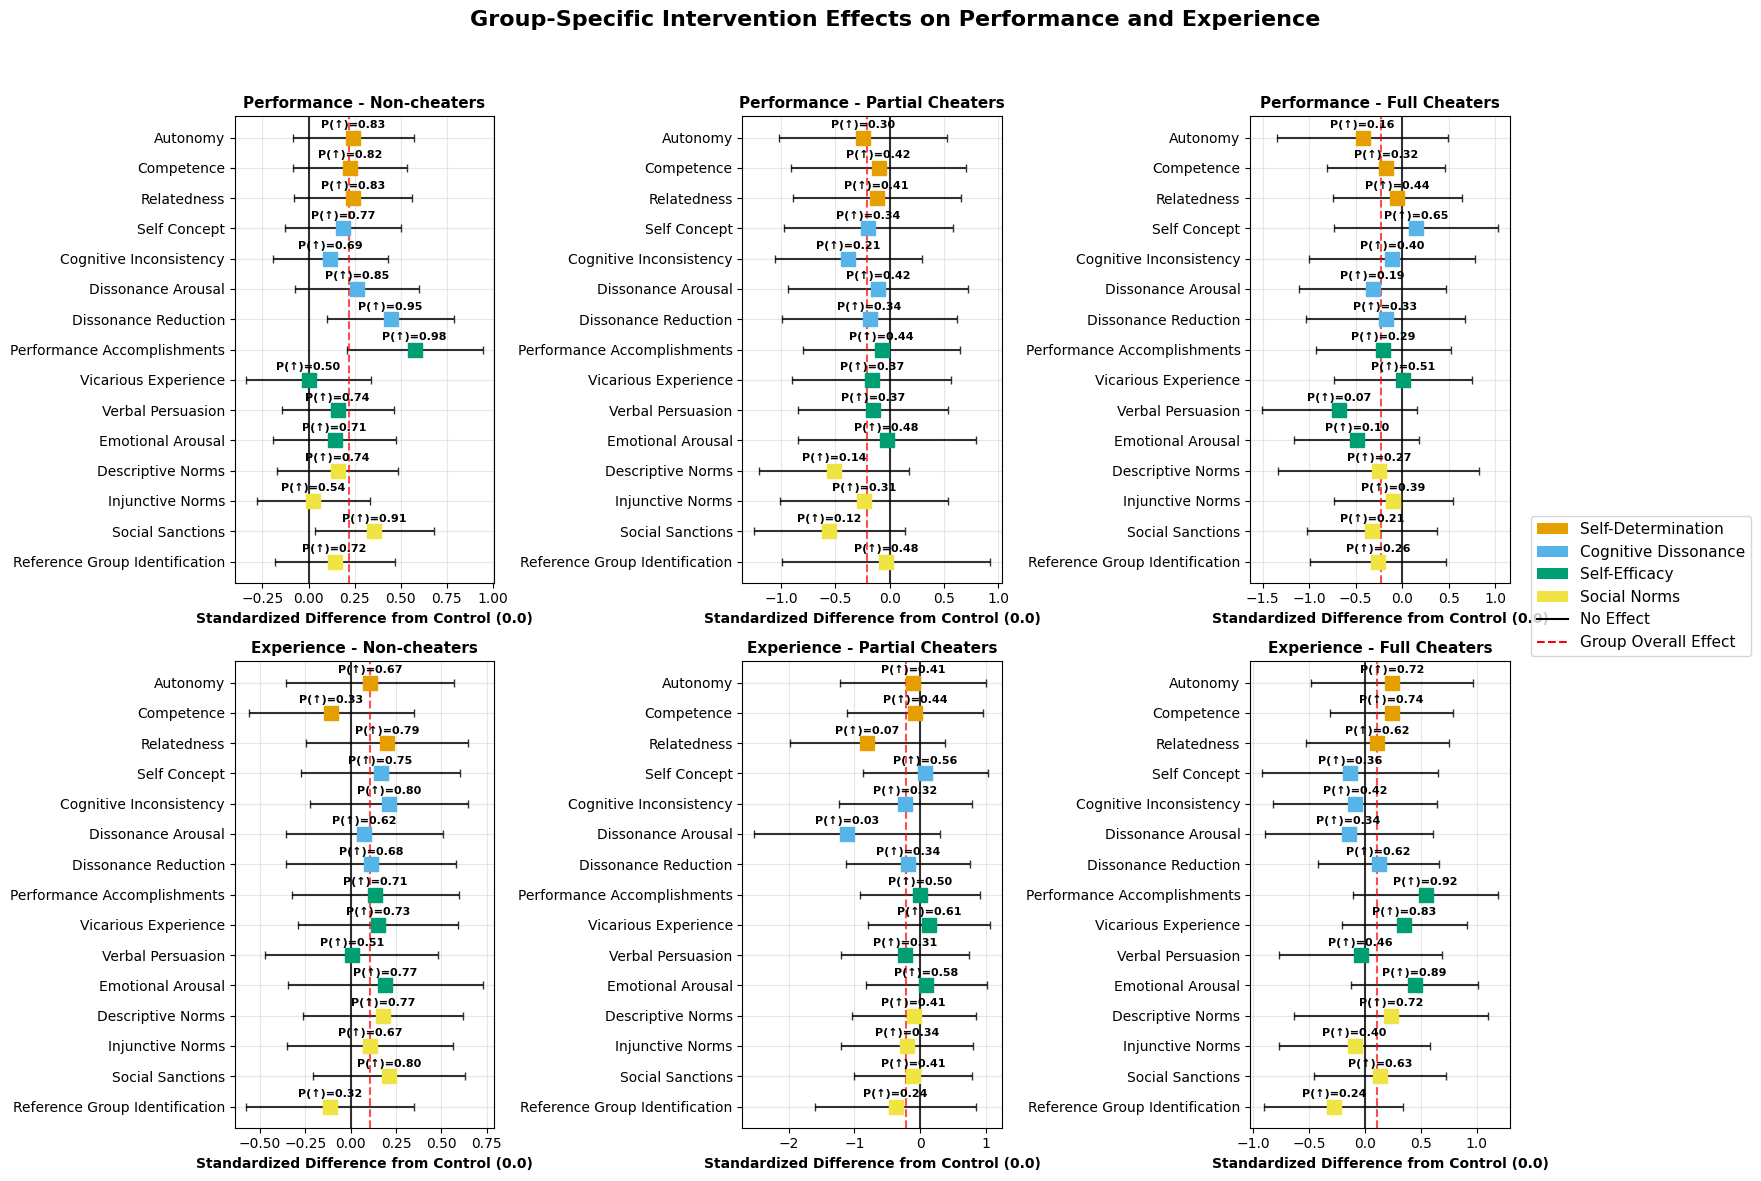

In [ ]:
# =====================
# RQ1 VISUALIZATION
# =====================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Theory colors and concept ordering
theory_colors = {
    "autonomy": "#E69F00", "competence": "#E69F00", "relatedness": "#E69F00",
    "self_concept": "#56B4E9", "cognitive_inconsistency": "#56B4E9", 
    "dissonance_arousal": "#56B4E9", "dissonance_reduction": "#56B4E9",
    "performance_accomplishments": "#009E73", "vicarious_experience": "#009E73", 
    "verbal_persuasion": "#009E73", "emotional_arousal": "#009E73",
    "descriptive_norms": "#F0E442", "injunctive_norms": "#F0E442", 
    "social_sanctions": "#F0E442", "reference_group_identification": "#F0E442"
}

theory_order = [
    "autonomy", "competence", "relatedness",
    "self_concept", "cognitive_inconsistency", "dissonance_arousal", "dissonance_reduction",
    "performance_accomplishments", "vicarious_experience", "verbal_persuasion", "emotional_arousal",
    "descriptive_norms", "injunctive_norms", "social_sanctions", "reference_group_identification"
]

# Extract concept-specific effects from traces
def extract_concept_effects():
    """Extract standardized effects for all concepts from Model 2 traces"""
    # Get posterior samples
    beta_cheat = trace_cheating.posterior['concept_effects_partialcheaters'].values.reshape(-1, len(concepts))
    beta_cheat_full = trace_cheating.posterior['concept_effects_fullcheaters'].values.reshape(-1, len(concepts))
    beta_perf = trace_performance.posterior['concept_main_effects'].values.reshape(-1, len(concepts))
    beta_exp = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    
    # Calculate combined cheating effect (average of partial and full)
    beta_cheat_combined = (beta_cheat + beta_cheat_full) / 2
    
    results = []
    for i, concept in enumerate(concepts):
        if concept in theory_order:
            # Standardize effects
            cheat_d = beta_cheat_combined[:, i] * np.sqrt(3) / np.pi
            perf_d = beta_perf[:, i] / perf_std
            exp_d = beta_exp[:, i] / exp_std
            
            results.append({
                'concept': concept,
                'label': concept.replace('_', ' ').title(),
                'color': theory_colors[concept],
                'cheat_d': cheat_d.mean(),
                'cheat_hdi': [np.percentile(cheat_d, 2.5), np.percentile(cheat_d, 97.5)],
                'cheat_prob': (cheat_d < 0).mean(),
                'perf_d': perf_d.mean(),
                'perf_hdi': [np.percentile(perf_d, 2.5), np.percentile(perf_d, 97.5)],
                'perf_prob': (perf_d > 0).mean(),
                'exp_d': exp_d.mean(),
                'exp_hdi': [np.percentile(exp_d, 2.5), np.percentile(exp_d, 97.5)],
                'exp_prob': (exp_d > 0).mean()
            })
    
    # Sort by theory order
    ordered_results = []
    for concept in reversed(theory_order):
        for r in results:
            if r['concept'] == concept:
                ordered_results.append(r)
                break
    
    return ordered_results

def calculate_group_specific_effects(cheating_group, outcome):
    """Calculate concept effects for specific cheating group"""
    group_code = {'non': 0, 'partial': 1, 'full': 2}[cheating_group]
    group_data = df[df['cheating_behavior'] == group_code]
    control_group = group_data[group_data['concept'] == 'control']
    
    if len(control_group) < 5:
        return [], 0.0
    
    results = []
    effects = []
    std_divisor = perf_std if outcome == 'performance' else exp_std
    
    for concept in reversed(theory_order):
        if concept in concepts:
            concept_group = group_data[group_data['concept'] == concept]
            if len(concept_group) >= 5:
                concept_mean = concept_group[outcome].mean()
                control_mean = control_group[outcome].mean()
                effect = (concept_mean - control_mean) / std_divisor
                effects.append(effect)
                
                # Calculate uncertainty
                n_concept, n_control = len(concept_group), len(control_group)
                n_eff = (n_concept * n_control) / (n_concept + n_control)
                z_score = effect * np.sqrt(n_eff / 2)
                prob = 1 / (1 + np.exp(-2 * z_score))
                
                # Confidence interval
                concept_se = concept_group[outcome].std() / np.sqrt(n_concept)
                control_se = control_group[outcome].std() / np.sqrt(n_control)
                combined_se = np.sqrt(concept_se**2 + control_se**2) / std_divisor
                hdi = [effect - 1.96*combined_se, effect + 1.96*combined_se]
                
                results.append({
                    'label': concept.replace('_', ' ').title(),
                    'color': theory_colors[concept],
                    'effect': effect,
                    'hdi': hdi,
                    'prob': prob
                })
    
    overall_effect = np.mean(effects) if effects else 0.0
    return results, overall_effect

def plot_effects(ax, results, effect_key, hdi_key, prob_key, title, xlabel, overall_effect, is_reduction=False):
    """Create standardized effect plot"""
    if not results:
        return
    
    y_pos = range(len(results))
    
    # Plot points and error bars
    for i, r in enumerate(results):
        effect = r[effect_key] if effect_key in r else r['effect']
        hdi = r[hdi_key] if hdi_key in r else r['hdi']
        prob = r[prob_key] if prob_key in r else r['prob']
        
        ax.scatter(effect, i, color=r['color'], marker='s', s=100, zorder=3)
        ax.errorbar(effect, i, xerr=[[effect - hdi[0]], [hdi[1] - effect]], 
                   fmt='none', color='black', capsize=3, alpha=0.8, zorder=2)
        
        arrow = '↓' if is_reduction else '↑'
        ax.text(effect, i + 0.25, f"P({arrow})={prob:.2f}", 
               ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Reference lines
    ax.axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=1.5, label='No Effect')
    ax.axvline(overall_effect, color='red', linestyle='--', alpha=0.7, linewidth=1.5, 
               label='Overall Effect')
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels([r['label'] for r in results], fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Get data
overall_results = extract_concept_effects()

# Calculate overall effects
overall_cheat = np.mean([r['cheat_d'] for r in overall_results])
overall_perf = np.mean([r['perf_d'] for r in overall_results])  
overall_exp = np.mean([r['exp_d'] for r in overall_results])

# FIGURE 1: Overall Effects (1x3)
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 8))

plot_specs1 = [
    (0, 'cheat_d', 'cheat_hdi', 'cheat_prob', 'Cheating Behavior', 
     'Standardized Difference from Control (0.0)', overall_cheat, True),
    (1, 'perf_d', 'perf_hdi', 'perf_prob', 'Performance', 
     'Standardized Difference from Control (0.0)', overall_perf, False),
    (2, 'exp_d', 'exp_hdi', 'exp_prob', 'Experience', 
     'Standardized Difference from Control (0.0)', overall_exp, False)
]

for i, (ax_idx, effect_key, hdi_key, prob_key, title, xlabel, overall_effect, is_reduction) in enumerate(plot_specs1):
    plot_effects(axes1[ax_idx], overall_results, effect_key, hdi_key, prob_key, 
                title, xlabel, overall_effect, is_reduction)

plt.suptitle('Overall Intervention Effects on All Outcomes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# FIGURE 2: Group-Specific Effects (2x3)
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))

# Calculate group-specific data
groups = ['non', 'partial', 'full']
group_labels = ['Non-cheaters', 'Partial Cheaters', 'Full Cheaters']
outcomes = ['performance', 'experience']
outcome_labels = ['Performance', 'Experience']

plot_specs2 = [
    # Row 1: Performance by group
    (0, 0, 'non', 'performance'),
    (0, 1, 'partial', 'performance'), 
    (0, 2, 'full', 'performance'),
    # Row 2: Experience by group
    (1, 0, 'non', 'experience'),
    (1, 1, 'partial', 'experience'),
    (1, 2, 'full', 'experience')
]

for row, col, group, outcome in plot_specs2:
    results, overall_effect = calculate_group_specific_effects(group, outcome)
    group_label = group_labels[groups.index(group)]
    outcome_label = outcome_labels[outcomes.index(outcome)]
    
    title = f'{outcome_label} - {group_label}'
    xlabel = f'Standardized Difference from Control (0.0)'
    
    plot_effects(axes2[row, col], results, 'effect', 'hdi', 'prob', 
                title, xlabel, overall_effect, False)

# Add legend
theory_legend = [
    ("Self-Determination", "#E69F00"), ("Cognitive Dissonance", "#56B4E9"),
    ("Self-Efficacy", "#009E73"), ("Social Norms", "#F0E442")
]
legend_elements = [Patch(facecolor=c, label=l) for l, c in theory_legend]
legend_elements += [
    plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='No Effect'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='Group Overall Effect')
]

fig2.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=11)
plt.suptitle('Group-Specific Intervention Effects on Performance and Experience', 
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()
